## Import packages

In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import (
    replay_run,
    replay_participation_all_replays,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import logging
from statannotations.Annotator import Annotator

logging.basicConfig(level=logging.INFO)

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load replay data

In [2]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_82422'
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_82622"

replay_df = replay_run.load_results(save_path, pre_task_post=False)


## run replay participation analysis

replay_participation_all_replays

# get many types of participation and firing

* combine linear and following sleep sessions to calc participation

* if no post sleep, only calc on linear track

* capture pre sleep participation



In [135]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_82622"

# v11 has partic_pad =0
# v12 has partic_pad =0.05
# v13 has partic_pad =0.025

save_path_cur_analysis = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_sleep_task_sleep_v11"
)
batch_analysis.run(
    replay_df,
    save_path_cur_analysis,
    replay_participation_all_replays.run,
    parallel=True,
    verbose=False,
    replay_df=replay_df.query("decoding_median_error<25"), # only keep good sessions
    replay_save_path=save_path,
    environments=["sleep", "linear", "sleep"],
    min_env_criteria = ["sleep", "linear"],
    epochs_to_combine=["linear", "sleep"],
    type_shuffle_for_replay="score_pval_time_swap",
    alpha=0.05,
    min_spk_count=0,
    partic_pad=0
)

# read back in
par_df = replay_participation_all_replays.load_result(save_path_cur_analysis)

100%|██████████| 95/95 [00:00<00:00, 1083.19it/s]


## add deep sup class from deep sup distance

In [136]:
par_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(par_df,hpc_assumption=False)
# par_df = add_new_deep_sup.add_new_deep_sup_class(par_df)
for basepath in par_df.basepath.unique():
    par_df.loc[par_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)


## plot replay partic prob. between layers

In [137]:
par_df.loc[par_df.epoch.str.contains("linear"),"epoch"] = "linear_sleep"

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linear_sleep_Deep vs. linear_sleep_Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:9.700e-01 U_stat=3.870e+04


(<AxesSubplot:xlabel='epoch', ylabel='replay participation prob.'>,
 [<statannotations.Annotation.Annotation at 0x1ffe034bb20>])

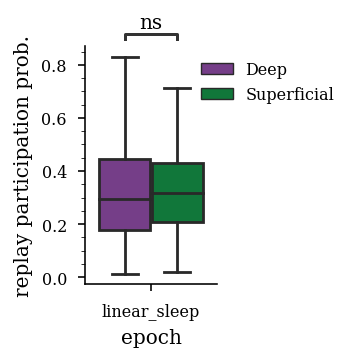

In [156]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

keep_idx = (
    (par_df.n_replays > 40)
    & par_df.epoch.str.contains("linear_sleep")
    & (par_df.animal_id != "HMC2")
)
sns.boxplot(
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)

plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_ylabel("replay participation prob.")

box_pairs = [
    (("linear_sleep", "Deep"), ("linear_sleep", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=par_df[keep_idx],
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()
# ax.set_ylim(-0.01,1)
# plt.savefig(
#     os.path.join(fig_save_path, "replay_participation_08_26_22.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )


In [155]:
basepath_mean_df = (
    par_df[par_df.epoch.str.contains("linear_sleep")]
    .groupby(["basepath"])
    .apply(
        lambda x: pd.Series(
            {
                "median_replay_par_deep": np.nanmedian(
                    x.query("deepSuperficial=='Deep'").replay_par
                ),
                "median_replay_par_sup": np.nanmedian(
                    x.query("deepSuperficial=='Superficial'").replay_par
                ),
                "animal_id":x.animal_id.unique()[0]
            }
        )
    )
    .reset_index()
)
basepath_mean_df["sup_over_deep"] = basepath_mean_df.median_replay_par_sup / basepath_mean_df.median_replay_par_deep
# basepath_mean_df.query("sup_over_deep <1").basepath.unique()
basepath_mean_df

,basepath,median_replay_par_deep,median_replay_par_sup,animal_id,sup_over_deep
0,Z:\Data\AYAold\AB1\day1,0.500000,0.500000,AB1,1.000000
1,Z:\Data\AYAold\AB3\AB3_38_41,0.000000,0.000000,AB3,NaN
2,Z:\Data\AYAold\AB3\AB3_42_46,0.000000,1.000000,AB3,inf
3,Z:\Data\AYAold\AYA4\day150726,NaN,NaN,AYA4,NaN
4,Z:\Data\AYAold\AYA4\day150804,NaN,NaN,AYA4,NaN
...,...,...,...,...,...
64,Z:\Data\Kenji\ec013.793_814,NaN,0.692308,ec013,NaN
65,Z:\Data\Kenji\ec014.459_480,0.269939,NaN,ec014,NaN
66,Z:\Data\Kenji\ec016.228_240,0.205882,0.294118,ec016,1.428571
67,Z:\Data\Kenji\ec016.267_278,0.318182,0.181818,ec016,0.571429


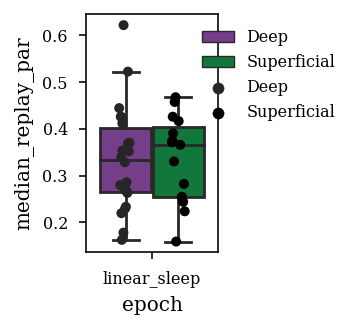

In [157]:
basepath_mean_df = (
    par_df[keep_idx]
    .groupby(["basepath", "epoch", "deepSuperficial"])
    .apply(lambda x: pd.Series({"median_replay_par": x.replay_par.median()}))
    .reset_index()
)

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
sns.boxplot(
    x="epoch",
    y="median_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=basepath_mean_df,
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="median_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=basepath_mean_df,
    dodge=True,
    color="k",
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)


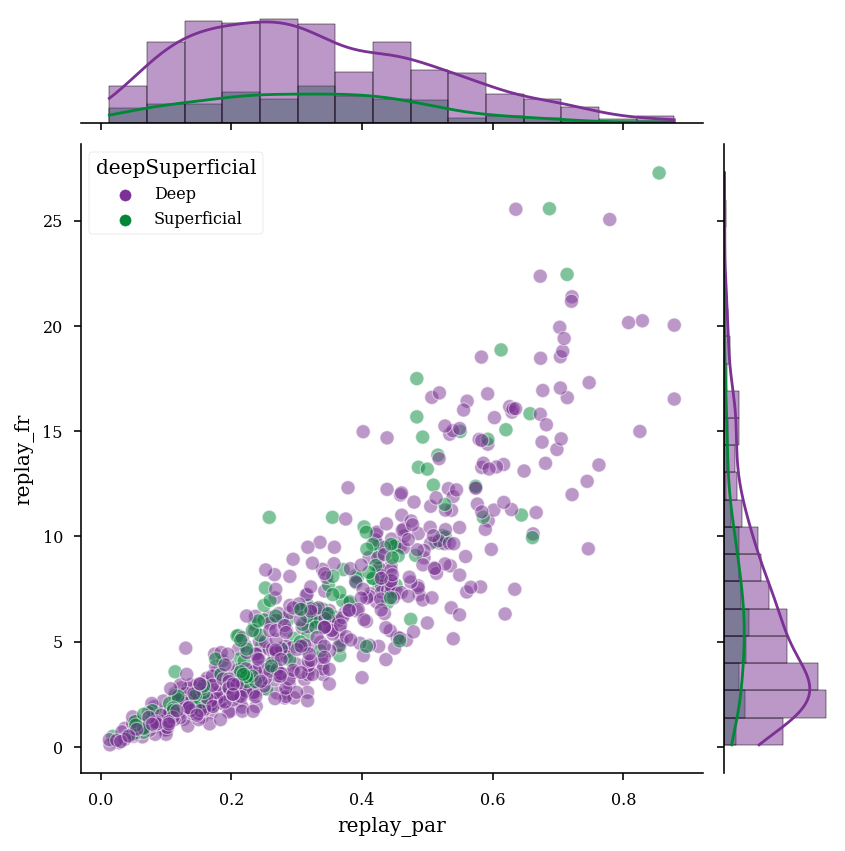

In [169]:
g = sns.JointGrid(
    data=par_df[keep_idx].query("deepSuperficial.str.contains('Deep|Superficial')"),
    x="replay_par",
    y="replay_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
g.plot_joint(sns.scatterplot, s=50, alpha=0.5)
g.plot_marginals(sns.histplot, kde=True, stat="probability")


In [ ]:
par_df[["basepath","UID"]].value_counts().reset_index()

In [11]:
test_df = (
    par_df[(par_df.epoch.str.contains("linear_sleep"))]
    .groupby(["basepath", "deepSuperficial"])
    .apply(lambda x: pd.Series({"replay_avg": x.replay_fr.median()}))
    .reset_index()
    .sort_values("replay_avg")
)
test_df.query("deepSuperficial.str.contains('Deep|Superficial')")[-30:-1]
# test_df

,basepath,deepSuperficial,replay_avg
24,Z:\Data\AYAold\AYA9\day17,Superficial,8.000000
36,Z:\Data\Can\OML22\day7,Superficial,8.055556
132,Z:\Data\Kenji\ec013.393_418,Deep,8.181818
135,Z:\Data\Kenji\ec013.564_585,Deep,8.333333
141,Z:\Data\Kenji\ec013.656_674,Deep,8.333333
44,Z:\Data\Can\OML23\day6,Deep,8.486239
41,Z:\Data\Can\OML23\day3,Deep,8.672249
30,Z:\Data\Can\OML22\day20,Superficial,9.150327
32,Z:\Data\Can\OML22\day6,Deep,9.265734
1,Z:\Data\AYAold\AB1\day1,Superficial,9.375000


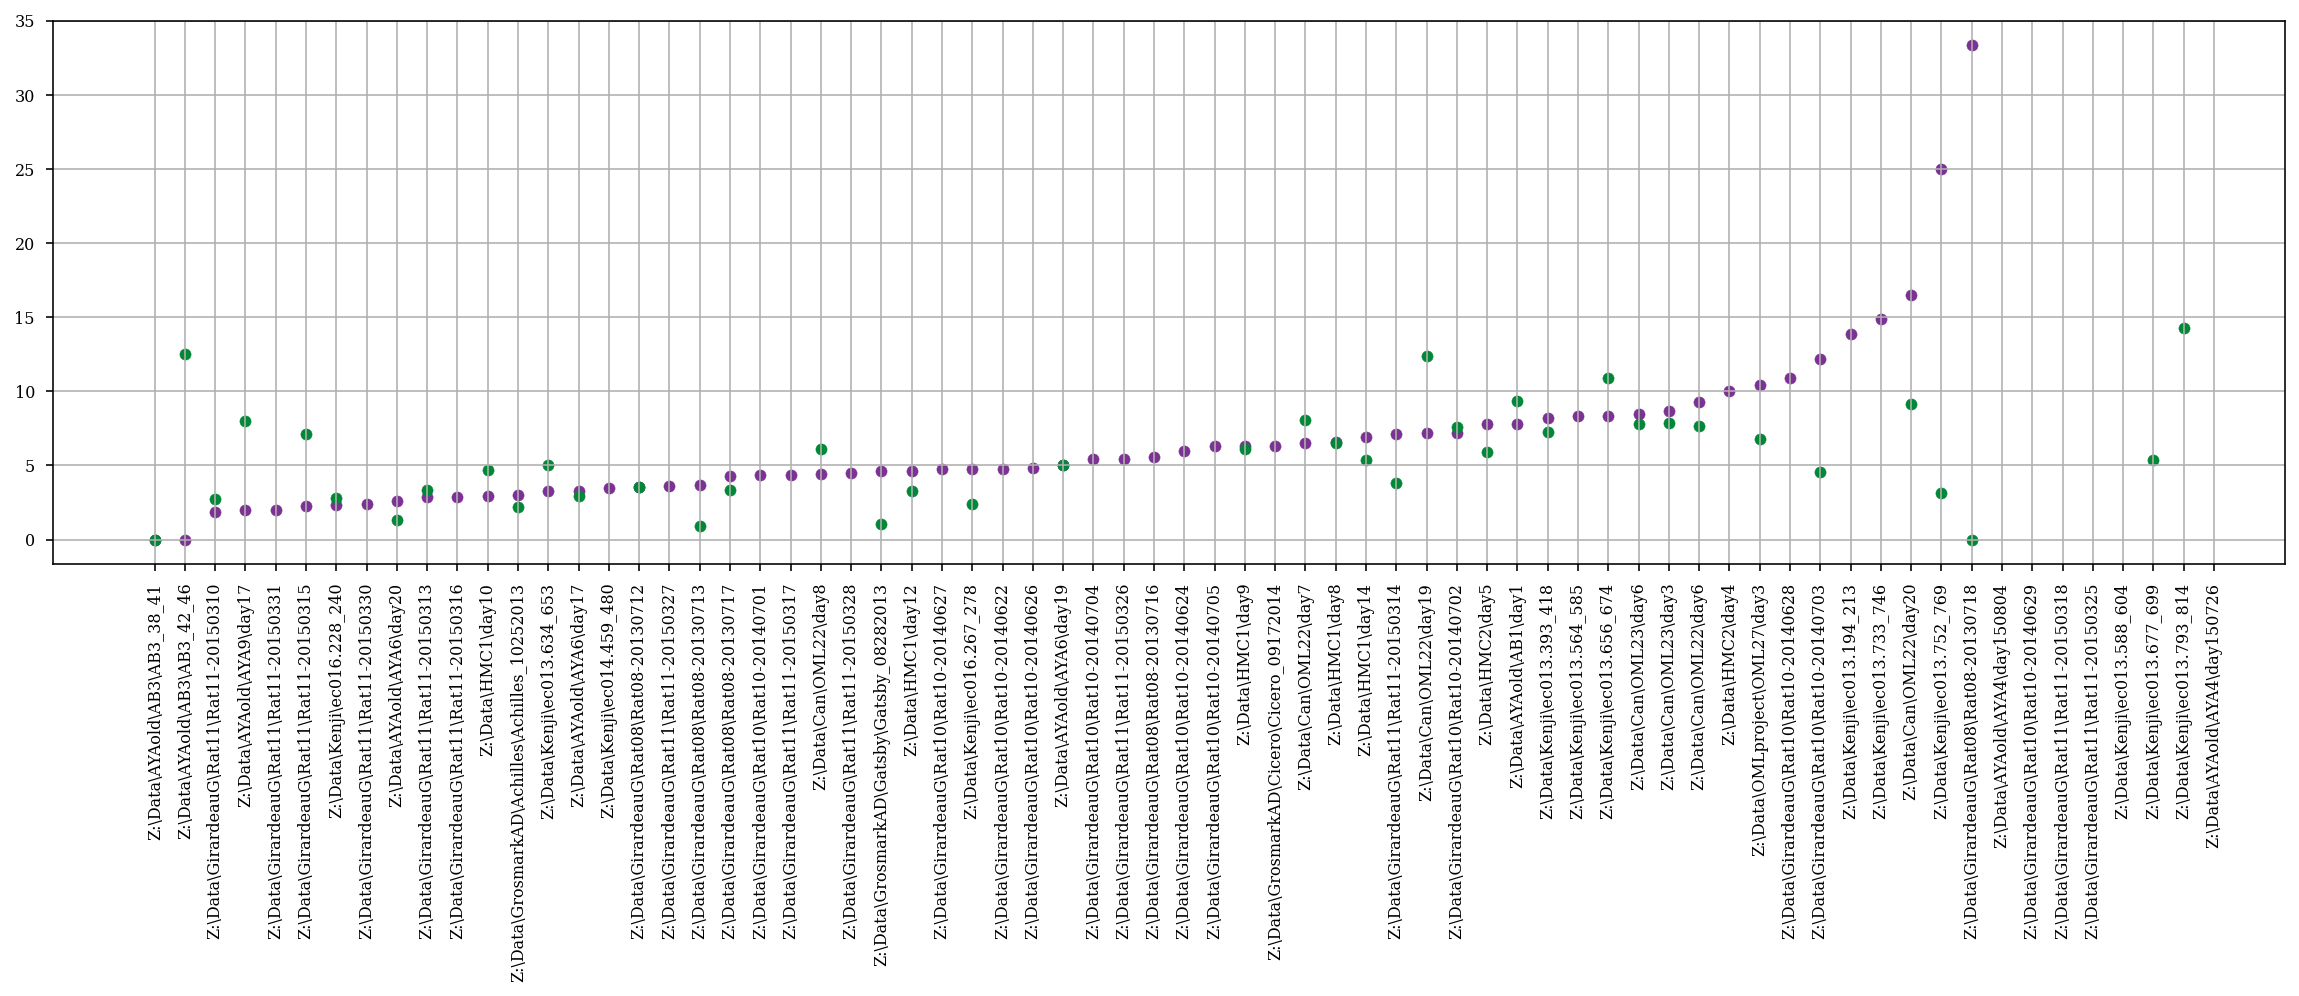

In [12]:
plt.figure(figsize=(20,5))

plt.scatter(test_df.query("deepSuperficial=='Deep'").basepath,test_df.query("deepSuperficial=='Deep'")["replay_avg"])
plt.scatter(test_df.query("deepSuperficial=='Superficial'").basepath,test_df.query("deepSuperficial=='Superficial'")["replay_avg"])
plt.grid()
plt.xticks(rotation=90)
plt.show()

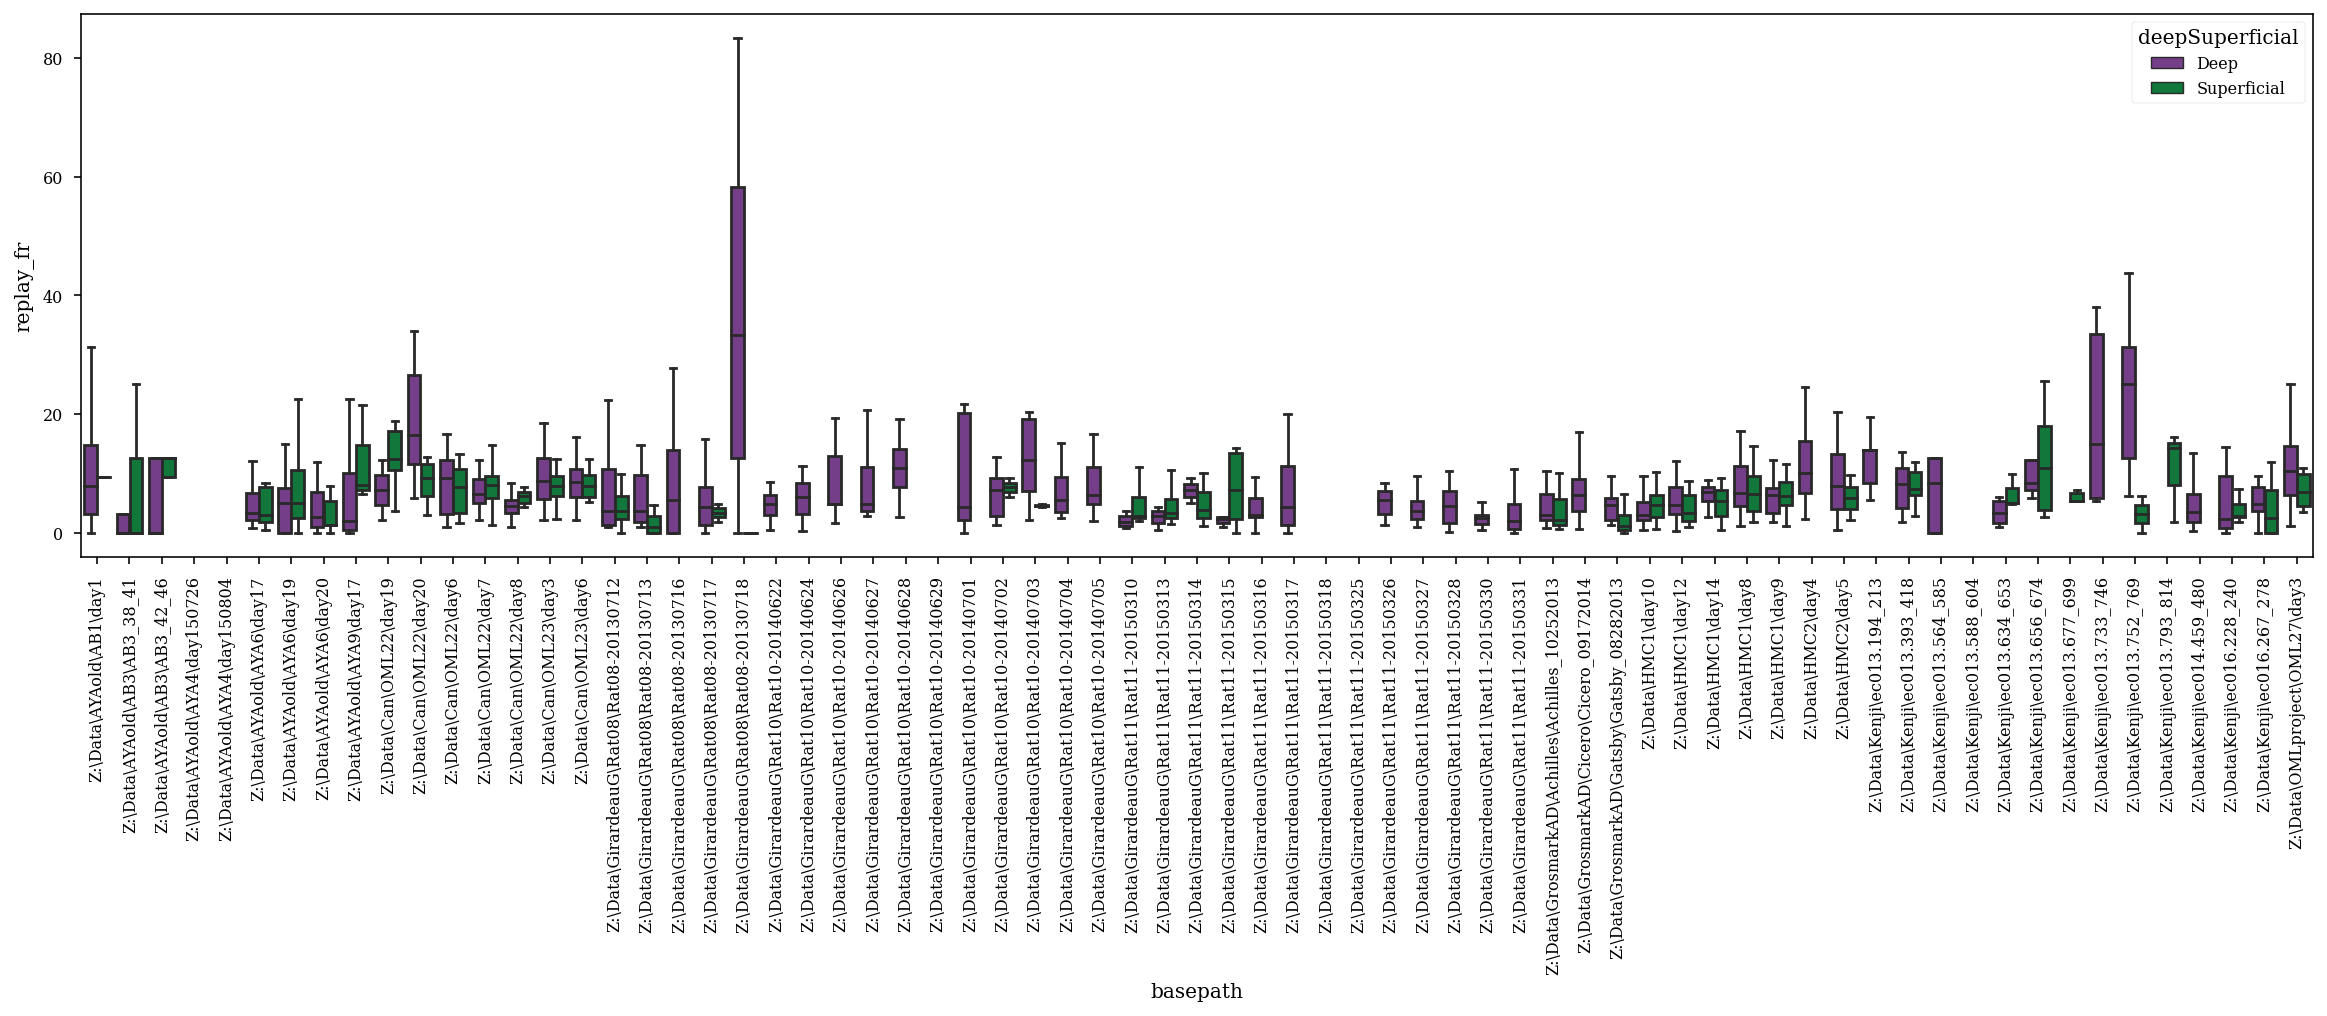

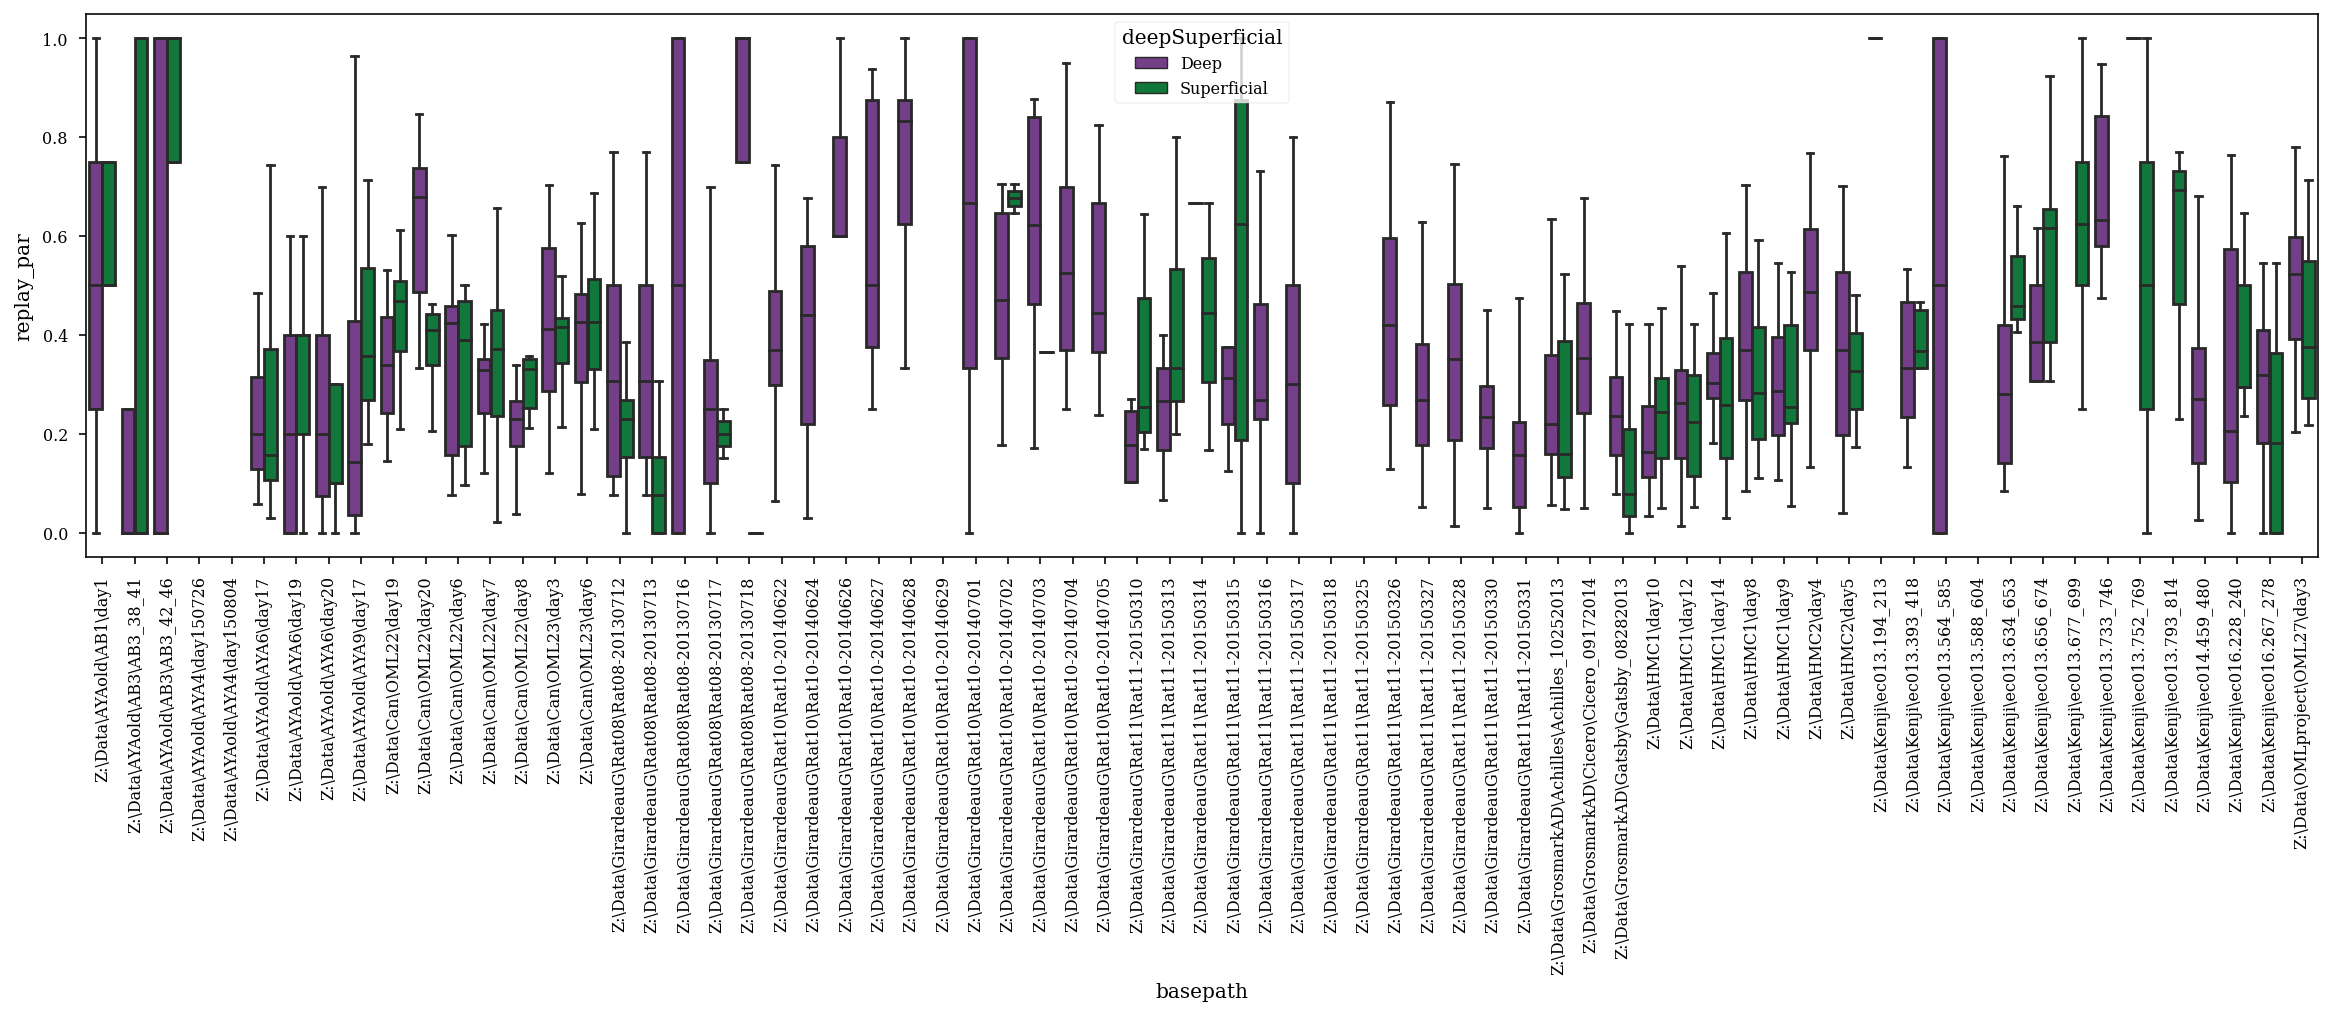

In [14]:
plt.figure(figsize=(20,5))
sns.boxplot(
    x="basepath",
    y="replay_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[par_df.epoch.str.contains("linear_sleep")],
    showfliers=False,
)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(20,5))
sns.boxplot(
    x="basepath",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[par_df.epoch.str.contains("linear_sleep")],
    showfliers=False,
)
plt.xticks(rotation=90)
plt.show()

In [171]:
from scipy.stats import ranksums
import statsmodels.api as sm

def do_the_glm(par_df,keep_idx):

    par_df["deepSuperficial"] = par_df["deepSuperficial"].replace(np.nan, "unknown")

    data = pd.DataFrame()
    data["replay_par"] = par_df[keep_idx].query("deepSuperficial.str.contains('Deep|Superficial')").replay_par.values
    data["deepSuperficial"] = (par_df[keep_idx].query("deepSuperficial.str.contains('Deep|Superficial')").deepSuperficial.values== "Deep") * 1
    data["n_replays"] = par_df[keep_idx].query("deepSuperficial.str.contains('Deep|Superficial')").n_replays.values
    data = sm.add_constant(data)
    data.dropna(inplace=True)

    logit_model = sm.GLM(
        data.replay_par,
        data[["const","deepSuperficial"]],
        freq_weights=data.n_replays,
        family=sm.families.Binomial(),
    )
    result = logit_model.fit()
    return result.pvalues.deepSuperficial 

In [172]:
keep_idx = (
    (par_df.n_replays > 40)
    & par_df.epoch.str.contains("linear_sleep")
    & (par_df.animal_id != "HMC2")
)
pval_replay_par = do_the_glm(par_df,keep_idx)
print(pval_replay_par)

x1 = par_df[keep_idx & (par_df.deepSuperficial == "Deep")].replay_fr.values
x2 = par_df[keep_idx & (par_df.deepSuperficial == "Superficial")].replay_fr.values
x1 = x1[~np.isnan(x1) & ~np.isinf(x1)]
x2 = x2[~np.isnan(x2) & ~np.isinf(x2)]
_,pval_replay_fr = ranksums(x1,x2)

print(pval_replay_fr)

1.1478205467987513e-13
0.03908613808431677


In [150]:
print(par_df[keep_idx].basepath.unique())
print(par_df[keep_idx].animal_id.unique())

['Z:\\Data\\Can\\OML22\\day19' 'Z:\\Data\\Can\\OML22\\day6'
 'Z:\\Data\\Can\\OML22\\day7' 'Z:\\Data\\Can\\OML22\\day8'
 'Z:\\Data\\Can\\OML23\\day3' 'Z:\\Data\\Can\\OML23\\day6'
 'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140622'
 'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140703'
 'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140705'
 'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150310'
 'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150327'
 'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150328'
 'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150330'
 'Z:\\Data\\GrosmarkAD\\Achilles\\Achilles_10252013'
 'Z:\\Data\\GrosmarkAD\\Cicero\\Cicero_09172014' 'Z:\\Data\\HMC1\\day10'
 'Z:\\Data\\HMC1\\day12' 'Z:\\Data\\HMC1\\day8' 'Z:\\Data\\HMC1\\day9'
 'Z:\\Data\\Kenji\\ec013.634_653' 'Z:\\Data\\Kenji\\ec014.459_480'
 'Z:\\Data\\OMLproject\\OML27\\day3']
['OML22' 'OML23' 'Rat10' 'Rat11' 'Achilles' 'Cicero' 'HMC1' 'ec013'
 'ec014' 'OML27']


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

linear_sleep_Deep vs. linear_sleep_Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:3.911e-02 U_stat=3.447e+04


(<AxesSubplot:ylabel='replay FR'>,
 [<statannotations.Annotation.Annotation at 0x20013880b20>])

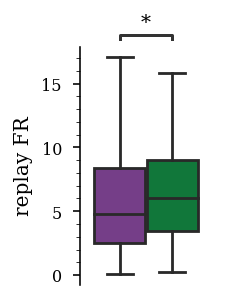

In [176]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

keep_idx = (
    (par_df.n_replays > 40)
    & par_df.epoch.str.contains("linear_sleep")
    & (par_df.animal_id != "HMC2")
)

# par_df["replay_fr_log"] = np.log(par_df.replay_fr)
sns.boxplot(
    x="epoch",
    y="replay_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("replay FR")

box_pairs = [
    (("linear_sleep", "Deep"), ("linear_sleep", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=par_df[keep_idx],
    x="epoch",
    y="replay_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)

annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

# plt.savefig(
#     os.path.join(fig_save_path, "replay_fr_08_26_22.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )


## See replay firing rate gain

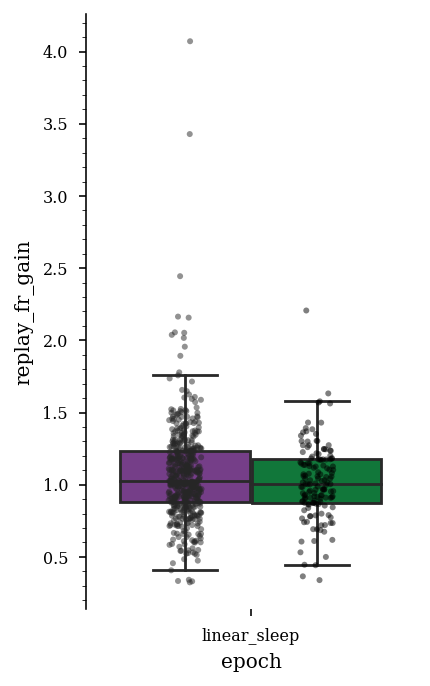

In [177]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

par_df["replay_fr_gain"] = par_df["replay_fr"] / par_df["non_replay_fr"]

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
# keep_idx = (par_df.n_replays > 30)

sns.boxplot(
    x="epoch",
    y="replay_fr_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="replay_fr_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
# ax.set_xlabel("")
# ax.set_ylabel("non_replay_fr firing rate (Hz)")

# ax.set_yscale("log")
# plt.savefig(
#     os.path.join(fig_save_path, "replay_fr_05_11_22.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )
# par_df[keep_idx].basepath.unique()

## Test python mixed lm model

In [178]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

temp_df = par_df[(par_df.deepSuperficial != "middle") & (par_df.n_replays > 30)]

lbl=LabelEncoder()
temp_df['basepath_encoded'] = lbl.fit_transform(temp_df[['basepath']])
temp_df['deepSuperficial_encoded'] = lbl.fit_transform(temp_df[['deepSuperficial']])

temp_df["Intercept"] = 1
exog = temp_df[["Intercept", "deepSuperficial_encoded"]]
md = sm.MixedLM(temp_df["replay_par"], exog, groups=temp_df["basepath_encoded"], exog_re=exog["Intercept"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    replay_par
No. Observations:     1660       Method:                REML      
No. Groups:           31         Scale:                 0.0289    
Min. group size:      10         Log-Likelihood:        539.6957  
Max. group size:      150        Converged:             Yes       
Mean group size:      53.5                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.353    0.017 21.116 0.000  0.320  0.386
deepSuperficial_encoded -0.046    0.010 -4.466 0.000 -0.066 -0.026
Intercept Var            0.008    0.013                           



## Forward / Reverse 

make wide to long df

In [179]:
# keep_idx = (par_df.n_replays > 30) & (par_df.epoch.str.contains("linear"))

par_df_long = pd.melt(
    par_df[keep_idx],
    id_vars=["basepath", "UID", "deepSuperficial"],
    value_vars=["forward_replay_par", "reverse_replay_par"],
    var_name="replay_type",
    value_name="replay_participation",
)
par_df_long


,basepath,UID,deepSuperficial,replay_type,replay_participation
0,Z:\Data\Can\OML22\day19,16,Superficial,forward_replay_par,0.400000
1,Z:\Data\Can\OML22\day19,18,Superficial,forward_replay_par,0.533333
2,Z:\Data\Can\OML22\day19,23,Deep,forward_replay_par,0.533333
3,Z:\Data\Can\OML22\day19,25,Superficial,forward_replay_par,0.533333
4,Z:\Data\Can\OML22\day19,26,Superficial,forward_replay_par,0.300000
...,...,...,...,...,...
1951,Z:\Data\OMLproject\OML27\day3,132,middle,reverse_replay_par,0.652778
1952,Z:\Data\OMLproject\OML27\day3,133,middle,reverse_replay_par,0.453704
1953,Z:\Data\OMLproject\OML27\day3,134,Deep,reverse_replay_par,0.412037
1954,Z:\Data\OMLproject\OML27\day3,135,middle,reverse_replay_par,0.689815


In [158]:
par_df_long.basepath.nunique()

36

### look at forward and reverse

[Text(0, 0, 'forward'), Text(1, 0, 'reverse')]

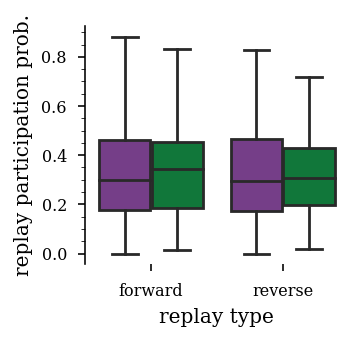

In [180]:
# fig = plt.figure(
#     figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
# )
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))

fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

g=sns.boxplot(
    x="replay_type",
    y="replay_participation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_long,
    showfliers=False,
)
ax = plt.gca()
ax.get_legend().remove()
sns.despine()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
# ax.get_legend().remove()
# ax.set_xlabel("")
# plt.xticks(['forward','reverse'], rotation='vertical')
ax.set_ylabel("replay participation prob.")
ax.set_xlabel("replay type")
g.set_xticklabels(['forward','reverse'])

# ax.set_ylim(0,1)

# plt.savefig(
#     os.path.join(fig_save_path, "replay_participation_for_rev.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

In [181]:
par_df_long['replay_type_ca1_layer'] = par_df_long['replay_type'] + '_' + par_df_long['deepSuperficial']
par_df_long['replay_type_ca1_layer'].unique()

array(['forward_replay_par_Superficial', 'forward_replay_par_Deep',
       'forward_replay_par_middle', 'forward_replay_par_unknown',
       'reverse_replay_par_Superficial', 'reverse_replay_par_Deep',
       'reverse_replay_par_middle', 'reverse_replay_par_unknown'],
      dtype=object)

### paired plot of forward and reverse

<AxesSubplot:xlabel='replay_type', ylabel='replay_participation'>

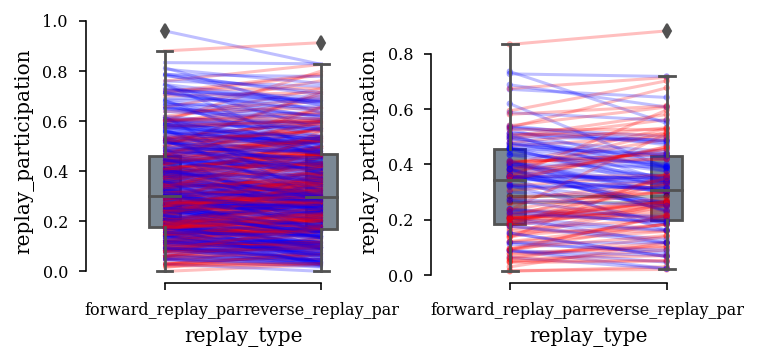

In [182]:
import pingouin as pg

fig, axs = plt.subplots(1, 2, figsize=functions.set_size(
    'thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace=.2, wspace=.1)
axs = axs.ravel()

ax = plt.gca()
par_df_long["basepath_UID"] = par_df_long.basepath + "_" + par_df_long.UID.astype(str)

pg.plot_paired(
    data=par_df_long[par_df_long.deepSuperficial == "Deep"],
    dv="replay_participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[0],
    pointplot_kwargs={"alpha": 0.25, "s": .5},colors=['r','k','b'],
)
pg.plot_paired(
    data=par_df_long[par_df_long.deepSuperficial == "Superficial"],
    dv="replay_participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[1],
    pointplot_kwargs={"alpha": 0.25},colors=['r','k','b']
)

In [183]:
# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# ) / (par_df.forward_replay_par + par_df.reverse_replay_par)

# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# )

par_df["forward_reverse_ratio"] = (
    par_df.forward_replay_par / par_df.reverse_replay_par
)

In [184]:
(par_df[par_df.deepSuperficial == "Deep"].forward_reverse_ratio > 1).sum()
(par_df[par_df.deepSuperficial == "Deep"].forward_reverse_ratio < 1).sum()

(par_df[par_df.deepSuperficial == "Superficial"].forward_reverse_ratio > 1).sum(),(par_df[par_df.deepSuperficial == "Superficial"].forward_reverse_ratio < 1).sum()

(296, 280)

### Forward / Reverse for main fig

Text(0, 0.5, 'Replay participation prob. \n Forward/reverse')

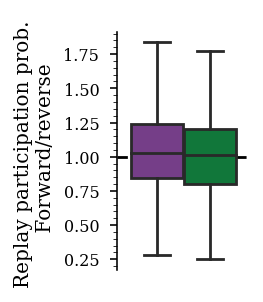

In [185]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    y="forward_reverse_ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
    # boxprops=dict(alpha=.7)

# sns.stripplot(
#     x="epoch",
#     y="forward_reverse_ratio",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.axhline(1, linestyle="--", color="k",zorder=-1000)

ax.set_ylabel("Replay participation prob. \n Forward/reverse")

# plt.savefig(
#     os.path.join(fig_save_path, "replay_participation_replay_type.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

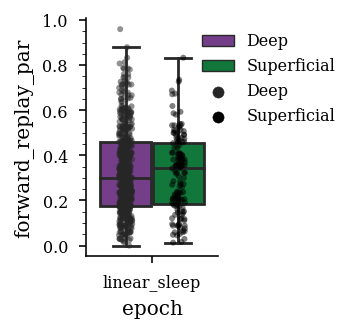

In [186]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

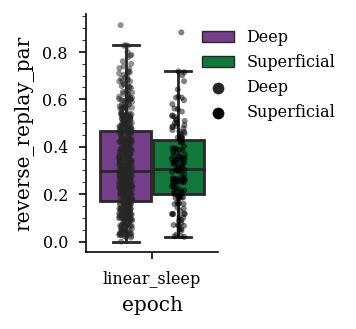

In [187]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

## calculate firing rate gain

$replayGain = \frac{replay fr}{avg fr}$

Text(0, 0.5, 'Replay gain \n (replay FR / avg FR)')

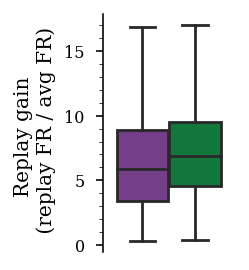

In [188]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

# par_df["replay_df_gain_avg_to_replay"] = (par_df.replay_fr-par_df.non_ripple_avg_fr)/(par_df.replay_fr+par_df.non_ripple_avg_fr)
par_df["replay_df_gain_avg_to_replay"] = par_df.replay_fr / par_df.non_ripple_avg_fr

# keep_idx = (
#     (par_df.n_replays > 30)
#     & (par_df.animal_id != "Rat08")
#     & (par_df.animal_id != "Gatsby")
#     & (par_df.animal_id != "OML22")
#     & (par_df.epoch.str.contains("linear"))
# )

sns.boxplot(
    x="epoch",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)

# sns.stripplot(
#     x="epoch",
#     y="replay_df_gain_avg_to_replay",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
# ax.axhline(1, linestyle="--", color="k",zorder=-1000)
ax.set_ylabel("Replay gain \n (replay FR / avg FR)")

# plt.savefig(
#     os.path.join(fig_save_path, "replay_fr_over_avg_fr.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

<AxesSubplot:xlabel='animal_id', ylabel='replay_df_gain_avg_to_replay'>

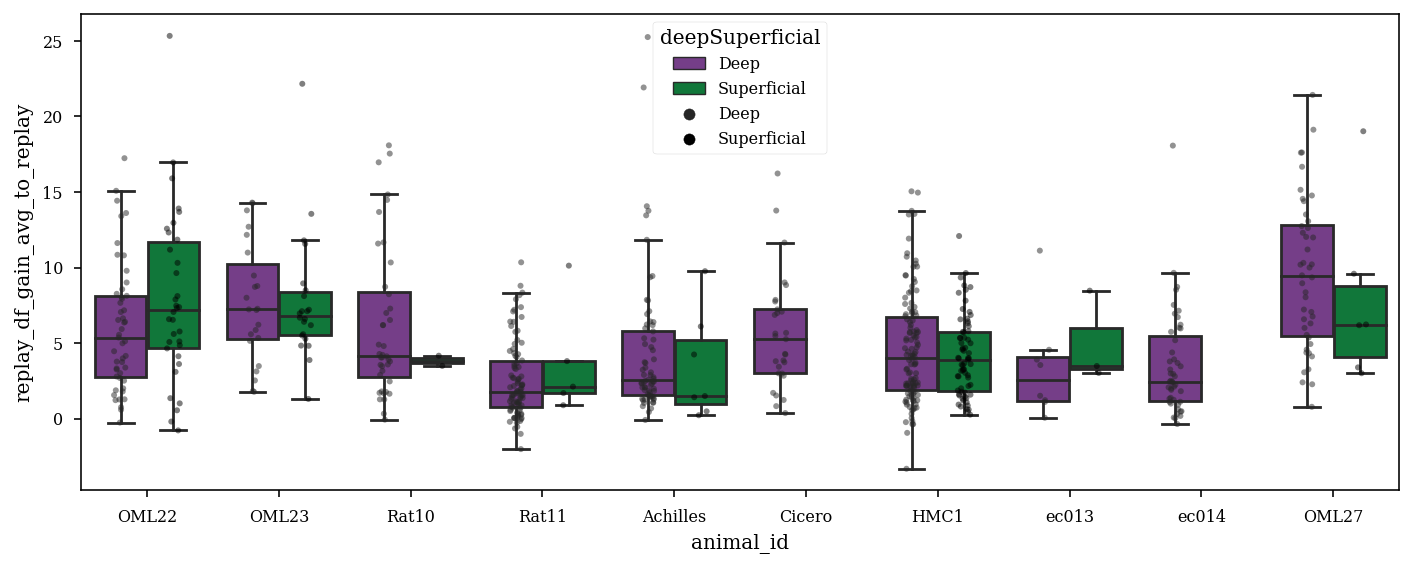

In [189]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=2, subplots=(3, 5)), edgecolor=None
)
par_df["replay_df_gain_avg_to_replay"] = (par_df.replay_fr-par_df.non_ripple_avg_fr)

sns.boxplot(
    x="animal_id",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="animal_id",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)

In [191]:
for animal_id in par_df[keep_idx].animal_id.unique():
    print(animal_id, ' deep ', sum((par_df[keep_idx].animal_id == animal_id) & (par_df[keep_idx].deepSuperficial == "Deep")))
    print(animal_id, ' sup ', sum((par_df[keep_idx].animal_id == animal_id) & (par_df[keep_idx].deepSuperficial == "Superficial")))


OML22  deep  49
OML22  sup  34
OML23  deep  23
OML23  sup  22
Rat10  deep  40
Rat10  sup  2
Rat11  deep  94
Rat11  sup  5
Achilles  deep  68
Achilles  sup  7
Cicero  deep  29
Cicero  sup  0
HMC1  deep  122
HMC1  sup  69
ec013  deep  8
ec013  sup  3
ec014  deep  47
ec014  sup  0
OML27  deep  44
OML27  sup  6


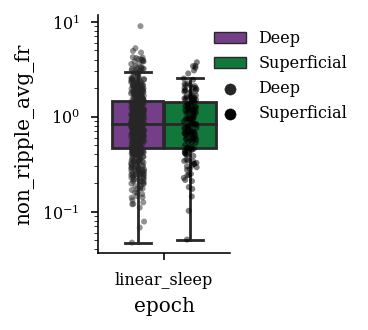

In [192]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="non_ripple_avg_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)

sns.stripplot(
    x="epoch",
    y="non_ripple_avg_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.yscale("log")

## Ripple gain pre-sleep norm

$replayGain = \frac{ReplayFr}{preSleepAvgFr}$


In [18]:
# par_df_wide = pd.pivot(
#     par_df[keep_idx], index=["UID","basepath","deepSuperficial"], columns="epoch", values=["replay_fr","avg_fr"]
# ).reset_index()
# par_df_wide

# par_df_wide["replay_gain"] = par_df_wide["replay_fr"]["linear_sleep"] / par_df_wide["avg_fr"]["sleep"]
# # par_df_wide["avg_fr"]["sleep"]
# par_df_wide

In [19]:
# par_df_wide[par_df_wide.basepath == "Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"]
# par_df[par_df.basepath == "Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"].epoch.value_counts()

# par_df

In [ ]:
# keep_idx = par_df.n_replays > 28

par_df_wide = pd.pivot(
    par_df[keep_idx],
    index=["UID", "basepath", "deepSuperficial"],
    columns="epoch",
    values=["replay_fr", "avg_fr"],
).reset_index()

par_df_wide["replay_gain"] = par_df_wide["replay_fr"]["linear_sleep"] / par_df_wide["avg_fr"]["sleep"]
# par_df_wide["replay_gain"] = (
#     par_df_wide["replay_fr"]["linear_sleep"] - par_df_wide["avg_fr"]["sleep"]
# ) / (par_df_wide["replay_fr"]["linear_sleep"] + par_df_wide["avg_fr"]["sleep"])

par_df_wide["constant"] = 1

for basepath in par_df_wide.basepath.unique():
    par_df_wide.loc[
        par_df_wide.basepath == basepath, "animal_id"
    ] = loading.get_animal_id(basepath)
par_df_wide = par_df_wide[
    ["UID", "basepath", "deepSuperficial", "animal_id", "replay_gain", "constant"]
]
par_df_wide = par_df_wide[~np.isnan(par_df_wide.replay_gain)]
par_df_wide


In [173]:
# describe par_df_wide
par_df_wide.describe()
print(par_df_wide.basepath.value_counts())
print(par_df_wide.deepSuperficial.value_counts())


Z:\Data\GrosmarkAD\Achilles\Achilles_10252013    105
Z:\Data\OMLproject\OML27\day3                     95
Z:\Data\GrosmarkAD\Achilles\Achilles_11012013     89
Z:\Data\HMC1\day13                                84
Z:\Data\HMC1\day10                                77
Z:\Data\HMC1\day9                                 59
Z:\Data\HMC1\day12                                59
Z:\Data\Can\OML22\day6                            56
Z:\Data\Can\OML22\day8                            52
Z:\Data\GrosmarkAD\Cicero\Cicero_09102014         50
Z:\Data\Kenji\ec014.459_480                       49
Z:\Data\HMC2\day5                                 48
Z:\Data\Can\OML22\day7                            46
Z:\Data\GrosmarkAD\Cicero\Cicero_09172014         43
Z:\Data\HMC1\day14                                40
Z:\Data\Can\OML23\day6                            39
Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013         36
Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013         35
Z:\Data\GrosmarkAD\Cicero\Cicero_09012014     

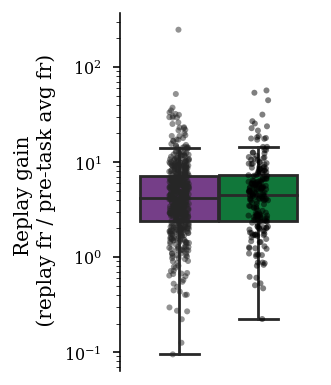

In [174]:

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(3, 1)), edgecolor=None
)

# keep_idx = (
#     (par_df_wide.animal_id != "Gatsby")
#     & (par_df_wide.animal_id != "ec014")
#     & (par_df_wide.animal_id != "achilles")
#     & (par_df_wide.animal_id != "Rat11")
# )
par_df_wide["consider_remove"] = False
for basepath in par_df_wide.basepath.unique():
    deep_idx = np.sum(par_df_wide[par_df_wide.basepath == basepath].deepSuperficial == "Deep") > 0
    sup_idx = np.sum(par_df_wide[par_df_wide.basepath == basepath].deepSuperficial == "Superficial") > 0
    if not deep_idx or not sup_idx:
        par_df_wide.loc[par_df_wide.basepath == basepath,"consider_remove"] = True

keep_idx = par_df_wide.consider_remove == False

sns.boxplot(
    x="constant",
    y="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide[keep_idx],
    showfliers=False,
)

sns.stripplot(
    x="constant",
    y="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
# ax.axhline(1, linestyle="--", color="k",zorder=-1000)

ax.set_ylabel("Replay gain \n (replay fr / pre-task avg fr)")
plt.yscale("log")

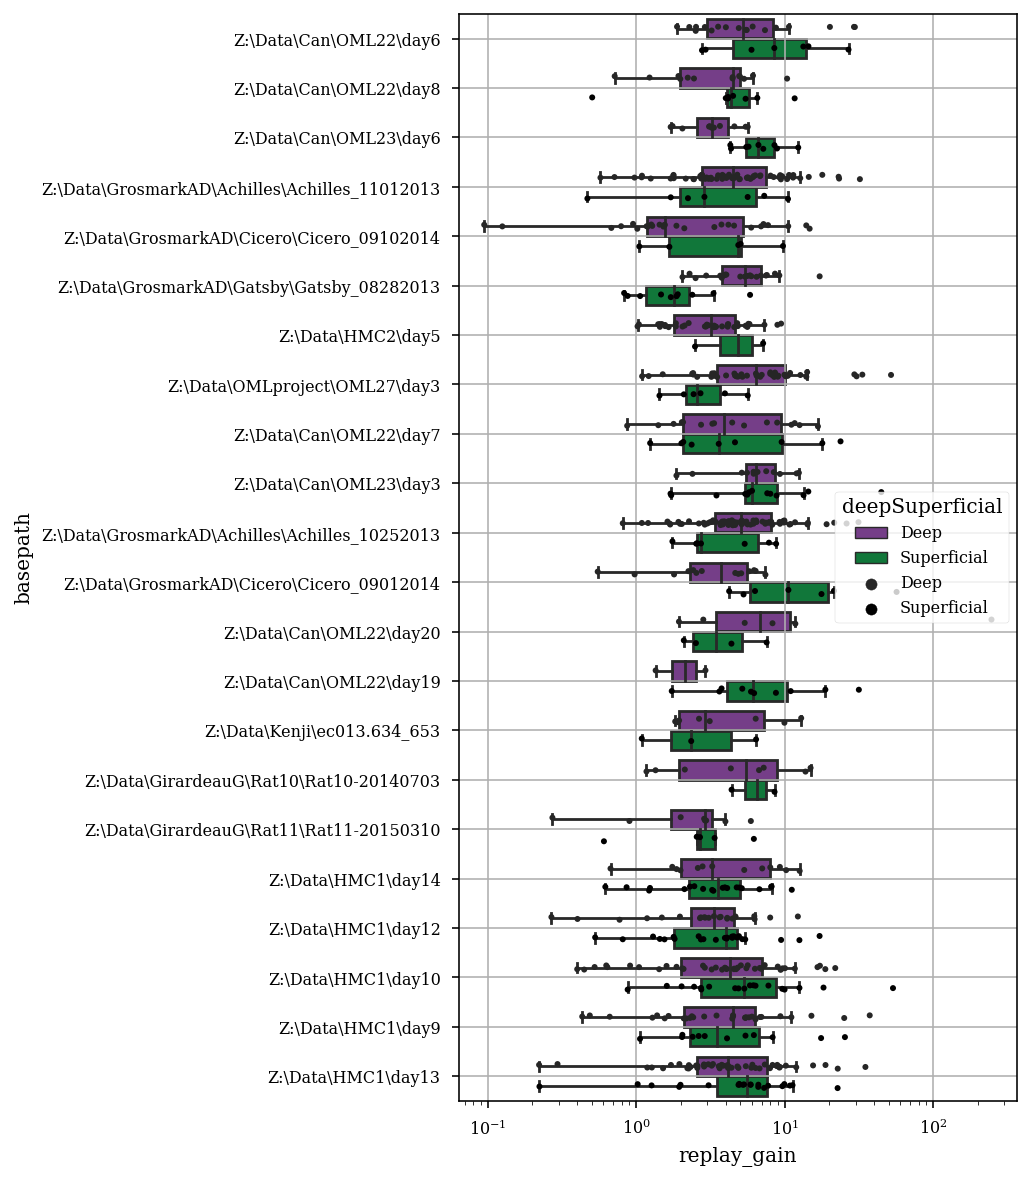

In [175]:
plt.figure(figsize=(5,10))
sns.boxplot(
    y="basepath",
    x="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide[keep_idx],
    showfliers=False,
)
sns.stripplot(
    y="basepath",
    x="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=1,
)
plt.xscale("log")
plt.grid()

In [ ]:
par_df_wide.to_csv(
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post_replay_gain.csv"
)

In [32]:
par_df.epoch.unique()

array(['sleep', 'linear', 'linear_sleep'], dtype=object)

## save csv

In [194]:
# par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_task_post.csv")
# replay_participation_for_all_sessions_task_post
par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post.csv")


In [195]:
par_df.query("epoch=='linear_sleep' & n_replays > 40 & deepSuperficial != 'middle'").animal_id.unique()

array(['OML22', 'OML23', 'Rat10', 'Rat11', 'Achilles', 'Cicero', 'HMC1',
       'HMC2', 'ec013', 'ec014', 'OML27'], dtype=object)

In [224]:
par_df.keys()

Index(['avg_fr', 'non_ripple_avg_fr', 'replay_fr', 'ripple_fr',
       'non_replay_fr', 'replay_par', 'ripple_par', 'non_replay_par',
       'forward_replay_par', 'reverse_replay_par', 'epoch', 'epoch_i', 'UID',
       'deepSuperficialDistance', 'n_replays', 'n_forward_replays',
       'n_reverse_replays', 'n_ripples', 'basepath', 'deepSuperficial',
       'animal_id'],
      dtype='object')

In [43]:
replay_supp_df = par_df.query("n_replays > 30 & animal_id != 'OML27' & epoch=='linear_sleep'").groupby("animal_id").apply(
    lambda x: pd.Series(
        {
            "n CA1deep": np.sum(x.deepSuperficial == "Deep"),
            "n CA1sup": np.sum(x.deepSuperficial == "Superficial"),
            "n CA1middle": np.sum(x.deepSuperficial == "middle"),
            "n_canidates": x.n_replay_canidates.unique().sum(),
            "n_replays": x.n_replays.unique().sum(),
        }
    )
).reset_index()
replay_supp_df["prop. of replay"] = replay_supp_df.n_replays / replay_supp_df.n_canidates
# replay_supp_df.to_latex(index=False)
replay_supp_df

,animal_id,n CA1deep,n CA1sup,n CA1middle,n_canidates,n_replays,prop. of replay
0,AYA6,23,12,6,589,35,0.059423
1,Achilles,131,14,49,4480,280,0.062500
2,Cicero,70,12,45,6386,317,0.049640
3,Gatsby,53,10,5,2881,133,0.046165
4,HMC1,186,111,90,11289,511,0.045265
5,HMC2,67,2,11,10104,504,0.049881
6,OML22,55,38,93,10435,496,0.047532
7,OML23,23,22,27,4652,223,0.047936
8,Rat10,68,2,7,3851,319,0.082836
9,Rat11,109,5,15,5080,318,0.062598


In [44]:
replay_supp_df["n CA1deep"].sum() + replay_supp_df["n CA1sup"].sum()

1071

In [151]:
keep_idx = (
    (par_df.n_replays > 40)
    & par_df.epoch.str.contains("linear_sleep")
    & (par_df.animal_id != "HMC2")
    # & (par_df.animal_id != "OML27")
)

replay_supp_df = par_df[keep_idx].groupby("animal_id").apply(
    lambda x: pd.Series(
        {
            "n CA1deep": np.sum(x.deepSuperficial == "Deep"),
            "n CA1sup": np.sum(x.deepSuperficial == "Superficial"),
            "n CA1middle": np.sum(x.deepSuperficial == "middle"),
            "n_canidates": x.n_replay_canidates.unique().sum(),
            "n_replays": x.n_replays.unique().sum(),
        }
    )
).reset_index()
replay_supp_df["prop. of replay"] = replay_supp_df.n_replays / replay_supp_df.n_canidates

replay_supp_df

,animal_id,n CA1deep,n CA1sup,n CA1middle,n_canidates,n_replays,prop. of replay
0,Achilles,68,7,30,1024,107,0.104492
1,Cicero,29,0,14,1967,99,0.050330
2,HMC1,122,69,72,8850,419,0.047345
3,OML22,49,34,87,9559,457,0.047808
4,OML23,23,22,27,4652,223,0.047936
5,OML27,44,6,36,6045,444,0.073449
6,Rat10,40,2,5,2820,245,0.086879
7,Rat11,94,5,15,4516,287,0.063552
8,ec013,8,3,9,1117,59,0.052820
9,ec014,47,0,2,1781,163,0.091522


In [152]:
replay_supp_df["n CA1deep"].sum() + replay_supp_df["n CA1sup"].sum()


672

In [ ]:
par_df[par_df.deepSuperficial.isna()][["UID","deepSuperficial","basepath"]]

In [326]:
par_df.query("epoch=='linear_sleep' & n_replays > 30 & deepSuperficial != 'middle' & animal_id == 'HMC2'").deepSuperficial

32           Deep
33           Deep
34           Deep
35           Deep
36           Deep
         ...     
88    Superficial
90           Deep
92           Deep
93           Deep
95           Deep
Name: deepSuperficial, Length: 69, dtype: object

## visualize with dabest

In [69]:
temp_df_1 = pd.DataFrame()
keep_idx = (par_df.n_replays > 30)
par_df['basepath_UID'] = par_df.basepath + "_" + par_df.UID.astype(str)

temp_df_1['forward'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].forward_replay_par.values
temp_df_1['reverse'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].reverse_replay_par.values
temp_df_1['ID'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].basepath_UID.values
temp_df_1['deepSuperficial'] = ["Deep"] * len(temp_df_1)

temp_df_2 = pd.DataFrame()
temp_df_2['forward'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].forward_replay_par.values
temp_df_2['reverse'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].reverse_replay_par.values
temp_df_2['ID'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].basepath_UID.values

temp_df_2['deepSuperficial'] = ["Superficial"] * len(temp_df_2)
temp_df = pd.concat([temp_df_1, temp_df_2],ignore_index=True)
temp_df

,forward,reverse,ID,deepSuperficial
0,0.312500,0.352941,Z:\Data\AYAold\AYA6\day17_27,Deep
1,0.125000,0.235294,Z:\Data\AYAold\AYA6\day17_33,Deep
2,0.187500,0.411765,Z:\Data\AYAold\AYA6\day17_36,Deep
3,0.437500,0.470588,Z:\Data\AYAold\AYA6\day17_37,Deep
4,0.375000,0.294118,Z:\Data\AYAold\AYA6\day17_40,Deep
...,...,...,...,...
1417,0.282609,0.375000,Z:\Data\HMC1\day9_290,Superficial
1418,0.630435,0.625000,Z:\Data\HMC1\day9_309,Superficial
1419,0.450000,0.687500,Z:\Data\Kenji\ec013.634_653_61,Superficial
1420,0.950000,0.812500,Z:\Data\Kenji\ec013.634_653_66,Superficial


In [ ]:
import dabest
multi_2group_paired = dabest.load(temp_df[temp_df['deepSuperficial'] == "Deep"], idx=("forward", "reverse"),
                                paired=True, id_col=("ID")
                                )
multi_2group_paired.mean_diff.plot()


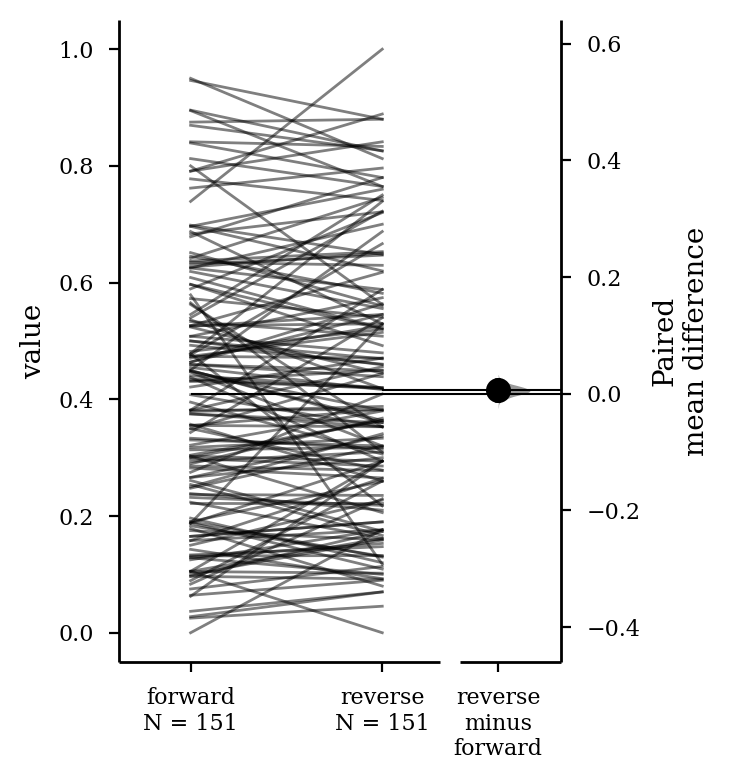

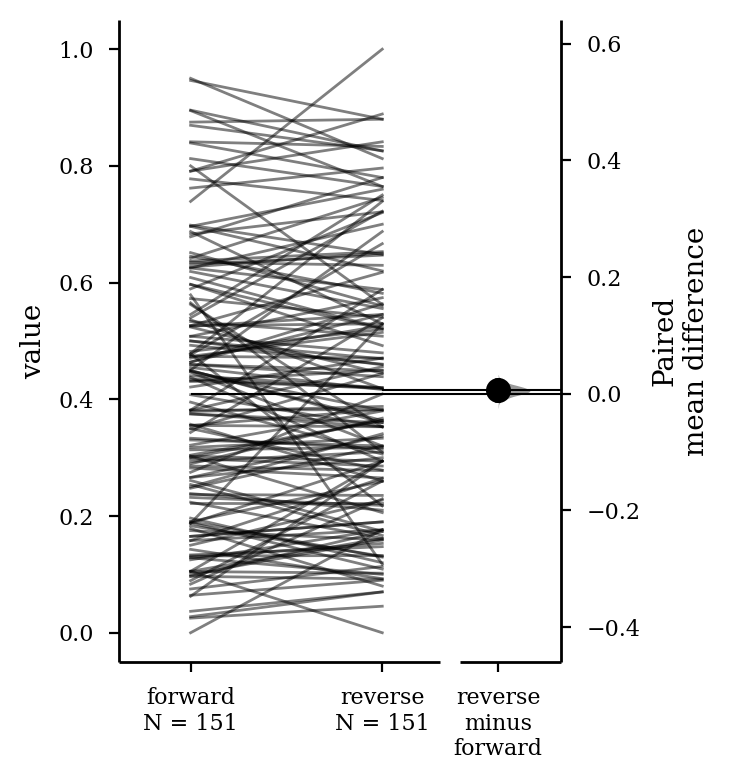

In [26]:
multi_2group_paired = dabest.load(temp_df[temp_df['deepSuperficial'] == "Superficial"], idx=("forward", "reverse"),
                                paired=True, id_col=("ID")
                                )
multi_2group_paired.mean_diff.plot()